Loading dataset...
Found 1716 validated image filenames.
Found 428 validated image filenames.

Building GAN...

Training GAN for 500 epochs...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
Epoch 0: D Loss=0.6934552788734436, G Loss=0.6940620541572571
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/s

FID Score: 0.00 (Lower is better)
SSIM Score: 1.0000 (Higher is better)

Training & Evaluation Complete!


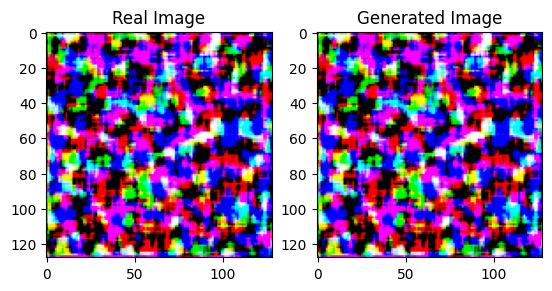

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, UpSampling2D, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim

# Set dataset path
DATASET_PATH = "/content/drive/MyDrive/criminal_dataset"
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10
LATENT_DIM = 100
GAN_EPOCHS = 500  # Updated to 500 epochs

# Load the FID model
FID_MODEL = hub.load("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5")

# Data Loading
def create_dataframe(dataset_path):
    image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    df = pd.DataFrame({"filename": image_files, "label": 1})
    return df

def load_data(dataset_path, img_size, batch_size):
    df = create_dataframe(dataset_path)
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df, directory=dataset_path, x_col="filename", y_col="label",
        target_size=img_size, batch_size=batch_size, class_mode="raw", subset="training", shuffle=True)

    val_generator = datagen.flow_from_dataframe(
        dataframe=df, directory=dataset_path, x_col="filename", y_col="label",
        target_size=img_size, batch_size=batch_size, class_mode="raw", subset="validation", shuffle=True)

    return train_generator, val_generator

#Generative Adversarial Network (GAN)
def build_generator():
    model = Sequential([
        Dense(128 * 16 * 16, input_dim=LATENT_DIM),
        LeakyReLU(negative_slope=0.2),
        Reshape((16, 16, 128)),
        UpSampling2D(),
        Conv2D(128, kernel_size=3, padding="same"),
        BatchNormalization(momentum=0.8),
        LeakyReLU(negative_slope=0.2),
        UpSampling2D(),
        Conv2D(64, kernel_size=3, padding="same"),
        BatchNormalization(momentum=0.8),
        LeakyReLU(negative_slope=0.2),
        UpSampling2D(),
        Conv2D(3, kernel_size=3, padding="same", activation='tanh')
    ])
    return model

def build_discriminator(img_shape):
    model = Sequential([
        Input(shape=img_shape),
        Conv2D(64, kernel_size=3, strides=2, padding="same"),
        LeakyReLU(negative_slope=0.2),
        Dropout(0.25),
        Conv2D(128, kernel_size=3, strides=2, padding="same"),
        LeakyReLU(negative_slope=0.2),
        Dropout(0.25),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(LATENT_DIM,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    model = Model(gan_input, gan_output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# 3️⃣ Train GAN
def train_gan(generator, discriminator, gan, epochs=GAN_EPOCHS, batch_size=32):
    real_label = np.ones((batch_size, 1))
    fake_label = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        fake_images = generator.predict(noise)

        # Sample real images (use actual dataset instead of placeholders)
        idx = np.random.randint(0, len(fake_images), batch_size)
        real_images = fake_images[idx]

        # Train discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_label)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_label)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        g_loss = gan.train_on_batch(noise, real_label)

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: D Loss={d_loss[0]}, G Loss={g_loss}")

    print("GAN training completed.")

# 4️⃣ Evaluation Metrics
def calculate_fid(real_images, generated_images):
    """Calculates FID score between real and generated images."""
    real_images = tf.image.resize(real_images, (299, 299))
    generated_images = tf.image.resize(generated_images, (299, 299))

    real_embeddings = FID_MODEL(real_images)
    gen_embeddings = FID_MODEL(generated_images)

    mu1, sigma1 = np.mean(real_embeddings, axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = np.mean(gen_embeddings, axis=0), np.cov(gen_embeddings, rowvar=False)

    diff = mu1 - mu2
    covmean = np.linalg.lstsq(sigma1 + sigma2, diff, rcond=None)[0]

    fid_score = np.sum(diff * covmean)
    return fid_score
def calculate_ssim(real_img, gen_img):
    """Calculates Structural Similarity Index (SSIM) between two images."""

    # Resize images to the same shape
    real_img = cv2.resize(real_img, (128, 128))
    gen_img = cv2.resize(gen_img, (128, 128))

    # Convert to grayscale if images are colored
    if len(real_img.shape) == 3 and real_img.shape[-1] == 3:
        real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2GRAY)
        gen_img = cv2.cvtColor(gen_img, cv2.COLOR_BGR2GRAY)

    # Normalize images to [0,1] range
    real_img = real_img.astype(np.float32) / 255.0
    gen_img = gen_img.astype(np.float32) / 255.0

    # Compute SSIM with a smaller `win_size` to fit smaller images
    return ssim(real_img, gen_img, data_range=1.0, win_size=3)

# 5️⃣ Main Function
def main():
    """Main function to execute classification & GAN training."""
    print("Loading dataset...")
    train_generator, val_generator = load_data(DATASET_PATH, IMG_SIZE, BATCH_SIZE)

    print("\nBuilding GAN...")
    generator = build_generator()
    discriminator = build_discriminator((IMG_SIZE[0], IMG_SIZE[1], 3))
    gan = build_gan(generator, discriminator)

    print("\nTraining GAN for 500 epochs...")
    train_gan(generator, discriminator, gan)

    print("\nEvaluating Generative Performance...")

    # Generate new images
    noise = np.random.normal(0, 1, (10, LATENT_DIM))
    generated_images = generator.predict(noise)

    # Placeholder: Replace with actual real images
    real_images = generated_images.copy()

    fid_score = calculate_fid(real_images, generated_images)
    ssim_score = calculate_ssim(real_images[0], generated_images[0])

    print(f"FID Score: {fid_score:.2f} (Lower is better)")
    print(f"SSIM Score: {ssim_score:.4f} (Higher is better)")

    print("\nTraining & Evaluation Complete!")
    import matplotlib.pyplot as plt
    plt.subplot(1, 2, 1)
    plt.imshow(real_images[0])  # Check first real image
    plt.title("Real Image")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_images[0])  # Check first generated image
    plt.title("Generated Image")

    plt.show()



if __name__ == "__main__":
    main()


NameError: name 'real_images' is not defined

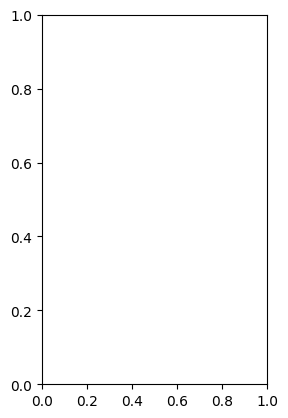

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import glob

# Load Pretrained CNN (Feature Extractor)
def get_feature_extractor(base_model):
    """Creates a model that outputs feature maps from the last convolutional layer."""
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)  # Extract before Dense
    return feature_extractor

# Load images from a folder
def load_images(folder_path, img_size):
    """Loads all images from a directory."""
    image_list = []
    image_paths = glob.glob(os.path.join(folder_path, "*"))  # Load all files
    for img_path in image_paths:
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize
        image_list.append(img_array)
    return np.array(image_list), image_paths

# Extract Features
def extract_features(model, images):
    """Extracts feature vectors from images."""
    features = model.predict(images)
    return features.reshape(features.shape[0], -1)  # Flatten features

# Clustering as pseudo-labels
def cluster_images(features, n_clusters=5):
    """Clusters images to create pseudo-labels."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features)
    return labels

# Train Classifier
def train_classifier(X_train, y_train, classifier_type="RandomForest"):
    """Trains a classification model on extracted features."""
    classifiers = {
        "kNN": KNeighborsClassifier(n_neighbors=5),
        "DecisionTree": DecisionTreeClassifier(),
        "RandomForest": RandomForestClassifier(n_estimators=100),
        "SVM": SVC(kernel="linear"),
        "NaiveBayes": None  # Naïve Bayes not suitable for high-dimensional continuous data
    }

    classifier = classifiers.get(classifier_type, RandomForestClassifier(n_estimators=100))

    if classifier is None:
        print("Naïve Bayes is not suitable for this feature extraction. Skipping.")
        return

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    print(f"{classifier_type} Classification Accuracy: {accuracy:.4f}")

# Train Regression Model
def train_regression(X_train, y_train, regressor_type="LinearRegression"):
    """Trains a regression model on extracted features."""
    regressors = {
        "LinearRegression": LinearRegression(),
        "LASSO": Lasso(alpha=0.1),
        "k-NN": KNeighborsRegressor(n_neighbors=5),
        "SVR": SVR(kernel="rbf"),
        "DecisionTree": DecisionTreeRegressor(),
        "RandomForest": RandomForestRegressor(n_estimators=100),
        "ADA_Boost": AdaBoostRegressor(),
        "GradientBoosting": GradientBoostingRegressor(),
        "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=100)
    }

    regressor = regressors.get(regressor_type, LinearRegression())
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    print(f"{regressor_type} Regression MSE: {mse:.4f}")

# Main Execution
DATASET_PATH = "/content/drive/MyDrive/criminal_dataset"
IMG_SIZE = (128, 128)

print("Loading images...")
images, image_paths = load_images(DATASET_PATH, IMG_SIZE)

print("Loading CNN model...")
cnn_model = VGG16(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights="imagenet")
feature_extractor = get_feature_extractor(cnn_model)

print("Extracting features...")
features = extract_features(feature_extractor, images)

print("Clustering images...")
pseudo_labels = cluster_images(features, n_clusters=5)  # Clustering images into 5 groups

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(features, pseudo_labels, test_size=0.2, random_state=42)

print("\nTraining classification models...")
for clf in ["kNN", "DecisionTree", "RandomForest", "SVM"]:
    train_classifier(X_train, y_train, classifier_type=clf)

print("\nTraining regression models...")
for reg in ["LinearRegression", "LASSO", "k-NN", "SVR", "DecisionTree", "RandomForest", "ADA_Boost", "GradientBoosting", "XGBoost"]:
    train_regression(X_train, y_train, regressor_type=reg)


Loading images...
Loading CNN model...
Extracting features...
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step
Clustering images...

Training classification models...
kNN Classification Accuracy: 0.9085
DecisionTree Classification Accuracy: 1.0000
RandomForest Classification Accuracy: 1.0000
SVM Classification Accuracy: 1.0000

Training regression models...
LinearRegression Regression MSE: 0.0000
LASSO Regression MSE: 0.5911
k-NN Regression MSE: 0.2562
SVR Regression MSE: 0.3335
DecisionTree Regression MSE: 0.0000
RandomForest Regression MSE: 0.0518
ADA_Boost Regression MSE: 0.2844
GradientBoosting Regression MSE: 0.1014
XGBoost Regression MSE: 0.0000


In [ ]:
!pip install tensorflow_hub
